In [1]:

# data from https://physionet.org/content/autonomic-aging-cardiovascular/1.0.0/
from cmath import isinf
import os
from tqdm.notebook import tqdm

import math
import threading

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import seaborn as sns

from py_files.extract import extract_data, extract_metadata
from bycycle import features, cyclepoints, plts
from scipy.signal import find_peaks
from scipy.signal import resample
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.fft import fft
from neurodsp.filt import filter_signal
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.spectral import compute_spectrum

import statsmodels.api as sm

# Import filter function
from neurodsp.filt import filter_signal

import bycycle

from matplotlib.pyplot import cm

from IPython.display import display

%matplotlib inline

# 25, 5, 10, 15
# 10 currently works best, sample size: 1
# data 0: 10
H_VAL = 10
DATA_ID = 1
# was 1
FREQ_HIGHPASS = 1

default_a = [2000, -2000, 2000, -2000, 2000]
default_b = [100, 200, 300, 400, 500]
default_c = [-0.001, -0.001, -0.001, -0.001, -0.001]
default_d = [0, 0, 0, 0, 0]

default_guess_a ,default_guess_c,default_guess_d = 2000,-0.001,0

# beginning at index 0 and increasing, find_max returns an index and value of the max value in the time series
def find_max(time_series=None, left=np.inf, right=-np.inf):
    errouneous_output = (-1, -np.inf)
    # bound checking
    if len(time_series) == 0:
        return errouneous_output
    if left < 0 or left > len(time_series):
        return errouneous_output
    if left > right:
        return errouneous_output
    if right > len(time_series):
        return errouneous_output
    # corner case
    if left == right:
        # super trivial result but what else?
        return (left, time_series[left])

    idx = -1
    max_val = time_series[0]
    for i in range(left, right):
        if time_series[i] > max_val:
            idx = i
            max_val = time_series[i]
    return(idx, max_val)


# find_max for min value
def find_min(time_series=None, left=np.inf, right=-np.inf):
    errouneous_output = (-1, -np.inf)
    # bound checking
    if len(time_series) == 0:
        return errouneous_output
    if left < 0 or left > len(time_series):
        return errouneous_output
    if left > right:
        return errouneous_output
    if right > len(time_series):
        return errouneous_output
    # corner case
    if left == right:
        # super trivial result but what else?
        return (left, time_series[left])
    idx = -1
    max_val = time_series[0]
    for i in range(left, right):
        if time_series[i] < max_val:
            idx = i
            max_val = time_series[i]
    return(idx, max_val)


# (f(x+h)-f(x))/h, where h is an integer
def disc_derivative(time_series, x_val, h_val):
    if x_val+h_val in range(0, len(time_series)):
        deriv = (time_series[x_val+h_val]-time_series[x_val])
        if deriv == 0:
            return 0
        if deriv > 0:
            return 1
        else:
            return -1
    return int(0)

# finds points where polarity of discrete derivative changes
def time_series_polarity_change(time_series, idx, offset, direction):
    if direction < 0:
        offset = -offset
    extreme_bound = None
    if direction > 0:
        extreme_bound = len(time_series)
    else:
        extreme_bound = 0
    initial_derivative = disc_derivative(
        time_series=time_series, x_val=idx, h_val=offset)
    while initial_derivative == 0:
        idx += offset
        initial_derivative = disc_derivative(
            time_series=time_series, x_val=idx, h_val=offset)
    for i in range(idx, extreme_bound, offset):
        new_derivative = disc_derivative(
            time_series=time_series, x_val=i, h_val=offset)
        if new_derivative != initial_derivative:
            return i

    return -1

#  this function plots lines between points on the time series starting
# at index i=0 and increasing by multiples of interval,
def linear_smoothing(time_series, interval):
    if type(interval) != int or len(time_series) == 0 or interval <= 0:
        return None
    retArray = np.zeros(len(time_series))
    iterations = math.floor(float(len(time_series))/float(interval))
    remainder = len(time_series) % interval
    for i in range(iterations):
        y2 = time_series[((i+1)*interval)-1]
        y1 = time_series[i*interval]
        # print(interval)
        slope = float(y2 - y1)/float(interval)
        for j in range(interval):
            retArray[i*interval + j] = time_series[i*interval] + j*slope
    if remainder > 0:
        y2 = time_series[i+remainder]
        y1 = time_series[i]
        slope = float(y2 - y1)/float(interval)
        for i in range(remainder):
            retArray[iterations*interval +
                     i] = time_series[iterations*interval] + i*slope
    return retArray


# returns time series for an unskewed gaussian
# with time series x, amplitude a, center index b, and 'negative narrowness' c.
def gaussian(x, a, b, c):
    return a*np.exp(c*((x-b)**2))


# returns time series for a skewed gaussian
# with time series x, amplitude a, center index b, and 'negative narrowness' c,
# and skew parameter d
def skewed_gaussian(x, a, b, c, d):
    center = b
    skew_param = d
    normal_gaussian = gaussian(x, a, b, c)
    cdf = norm.cdf(skew_param*(x-center))
    skewed_function = 2*cdf*normal_gaussian
    return skewed_function

# reduces an n-dimensional 4-tuple to an n-1-dimensional 4*n-tuple
# by unpacking each element of each element of the 4-tuple in the
# order: a0,b0,...,d0,a1,...,d(n-2),a(n-1),...,d(n-1)
def flatten_guesses(a, b, c, d):
    if len(a) != len(b) or len(c) != len(d):
        return "bad shape"
    if len(a) != len(c):
        return "bad shape"

    guesses = []
    lists = [a, b, c, d]
    for i in range(len(a)):
        for j in range(len(lists)):
            guesses.append(lists[j][i])        
    print(len(guesses))
    return guesses

# inverse to flatten_guesses
def build_guesses(width, *params):
    retVal=[]
    if len(params)%width!=0:
        print("length "+str(len(params)) + " is not divisible by "+ str(width))
        return None
    for i in range(width):
        retVal.append([])
    for i in range (len(params)):
        retVal[i%width].append(params[i])
    return retVal

# plots n superpositioned gaussian where n is the length of a,b,c, and d.
# a,b,c, and d are the (amp, center, neg narrowness, skew) values, respectively, for skewed_gaussian()
def n_skewed_gaussian(x, a, b, c, d):
    length = len(a)
    if len(b) != length or len(c) != length or len(d) != length:
        return "invalid arg set. a,b,c,d not all equal length"
    retData = np.zeros(len(x))
    for i in range(length):
        retData = retData+skewed_gaussian(x, a[i], b[i], c[i], d[i])
    return retData

# n_skewed_gaussian with (a,b,c,d) expanded
def CURVE_FIT_5_skewed_gaussian(x,*params):
    newParams=build_guesses(4,*params)
    return n_skewed_gaussian(x,*newParams)
    
# recursively prints shapes of lists. remove
def print_list_shape(list):
    shadow=list
    try:
        while len(shadow) > 0:
            print(len(shadow))
            shadow=shadow[0]
    except:
        return
    return

# plots unskewed gaussian
def plot_gaussian(x, a, b, c):
    func = a*np.exp(c*((x-b)**2))
    x = np.linspace(0, len(func), func)
    plt.plot(x, func)


# fits single gaussian to single signal. deprecated a bit?
def fit_curve(sig=None, p0=[], bounds=()):
    p, _ = curve_fit(f=skewed_gaussian, xdata=np.linspace(
        0, len(sig), len(sig)), ydata=sig, p0=p0, bounds=bounds)
    peakiness = gaussian_peakiness(sig, 0, len(sig), p[0])
    np.append(p, peakiness)
    return p

# this function should fit the curve as accurately as possible to n gaussians



# use all bounds
def fit_n_gaussian_general(x=None, n=0):

    # this function should fit the curve as accurately as possible with b values bounded by a list of ordered pairs.
    # designed for convenience.
    return -1

# generate flat bounds from tuple bounds
def generate_bounds(a, b, c, d):
    errstring = "wrong shape"
    errstring_1 = "empty argument"
    list = [a, b, c, d]
    retBounds = ([], [])
    
    
    if len(a) != len(b) or len(c) != len(d):
        return errstring
    if len(b) != len(d):
        return errstring
    if len(a) == 0:
        return errstring_1
    
    # shape check
    for i in range(len(list)):
        bound_set = list[i]
        for i in range(len(bound_set)):
            bound = bound_set[i]
            if len(bound) != 2:
                return errstring


    bound_length = len(a)
    for i in range(bound_length):
        for j in range(len(list)):
            bound_pair = list[j]
            currBound = bound_pair[i]
            retBounds[0].append(currBound[0])
            retBounds[1].append(currBound[1])
    return retBounds


# fits n gaussian curves, with bounds on center points specified.
# works well??
def fit_n_gaussian_center_bounds(x, b_bounds):

    if len(b_bounds[0]) != len(b_bounds[1]):
        return "bounds have different lengths"

    sz = len(b_bounds)
    a, c, d = [], [], []
    b = []
    a_guesses = []
    b_guesses = []
    c_guesses = []
    d_guesses = []
    guesses=None
    
    for i in range(sz):
        a.append((-1e20, 1e20))
        c.append((-1, 0))
        d.append((-1e20, 1e20))

    for i in range(sz):
        curr_bound = b_bounds[i]
        if np.isinf(curr_bound[0]) or np.isinf(curr_bound[1]):
            return "no infinite bounds supported yet. Please, use finite bounds."
        left = curr_bound[0]
        right = curr_bound[1]
        if left >= right:
            return "left bound >= right bound"
        b_guesses.append((left+right)/2)
        b.append((left, right))
        
        a_guesses.append(default_guess_a)
        c_guesses.append(default_guess_c)
        d_guesses.append(default_guess_d)

    # we must handle all good infinity edge cases, out of bounds, and the likes..

    bounds = generate_bounds(a, b, c, d)
    print(len(a_guesses))
    print(len(b_guesses))
    print(len(c_guesses))
    print(len(d_guesses))
    guesses=flatten_guesses(a_guesses,b_guesses,c_guesses,d_guesses)
    print_list_shape(guesses)
    for i in range(len(bounds[0])):
        if bounds[0][i] >= bounds[1][i]:
            print("bound at index "+ str(i)+" violates le/gt relationship")
    print("bounds: "+str(bounds))
    print("guesses: "+str(guesses))
    params = curve_fit(f=CURVE_FIT_5_skewed_gaussian, xdata=np.linspace(0, len(x), len(x)),
                       ydata=x,
                       p0=guesses,
                    #    bounds=bounds,
                       method='lm')
    # X0 must be one-dimensional...let's flatten the array.
    return params


# tgt is y value, time_series is the signal, left,right are bounds
# this function sweeps from 0 to len(time_series)
def find_intercepts_in_range(time_series, tgt, left, right):
    leq = bool(time_series[left] <= tgt)
    retslice = []
    for i in range(left, right):
        if leq and time_series[i] > tgt:
            retslice.append(i)
            leq = False
        elif (not leq) and time_series[i] <= tgt:
            retslice.append(i)
            leq = True
    return retslice

# this function begins at center, and finds the nearest left and right intercepts for the tgt y-value
def find_intercepts_telescoping(time_series, tgt, left_b, right_b, center):
    left = []
    right = []

    left_b = int(left_b)
    right_b = int(right_b)
    if left_b < 0 or right_b < 0 or left_b > right_b:
        return (left, right)
    if right_b > len(time_series):
        right_b = len(time_series)
    for i in range(center-left_b):
        last = time_series[center-i]
        this = time_series[center-i-1]
        # print("first loop: last="+str(last)+", this="+str(this))
        if last > tgt and this <= tgt:
            left.append(int(center-i-1))
            break
        if last <= tgt and this > tgt:
            left.append(int(center-i-1))
            break
    for i in range(right_b-center):
        last = time_series[center+i]
        this = time_series[center+i+1]
        # print("second loop: last="+str(last)+", this="+str(this))
        if last > tgt and this <= tgt:
            right.append(int(center+i+1))
            break
        if last <= tgt and this > tgt:
            right.append(int(center+i+1))
            break

    print("should be returning: "+str(left)+" and "+str(right))
    return left, right

# ideally, this function comments about the peakiness of an individual gaussian. I am tired, tho
def gaussian_peakiness(time_series, left, right, pol):
    H_VAL_PEAKINESS = 1

    if pol >= 0:
        max_idx, _ = find_max(time_series=time_series, left=left, right=right)
    else:
        max_idx, _ = find_min(time_series=time_series, left=left, right=right)

    if max_idx == -1:
        return 0
    peakedness = abs(time_series[max_idx] - time_series[max_idx-H_VAL_PEAKINESS]) + abs(
        time_series[max_idx] - time_series[max_idx+H_VAL_PEAKINESS])
    return peakedness


def shorten(sig, init_freq, tgt_freq):
    old_len = len(sig)
    new_len = int(float(tgt_freq)/float(init_freq)*float(len(sig)))
    result = resample(sig, new_len)
    return result, int((float(new_len)/float(old_len))*float(init_freq))



In [2]:
x=[0,1,2,3]
x=np.append(x,4)

x

array([0, 1, 2, 3, 4])

In [3]:
# Data paths
dir_path = '/home/guarian/HOME/coding/python/voytek_lab/ecg_param/data/'
files_dat = [i for i in sorted(os.listdir(dir_path)) if i.endswith('dat')]
files_hea = [i for i in sorted(os.listdir(dir_path)) if i.endswith('hea')]
files_hea = [i for i in files_hea if i != '0400.hea'] # missing one participant's data

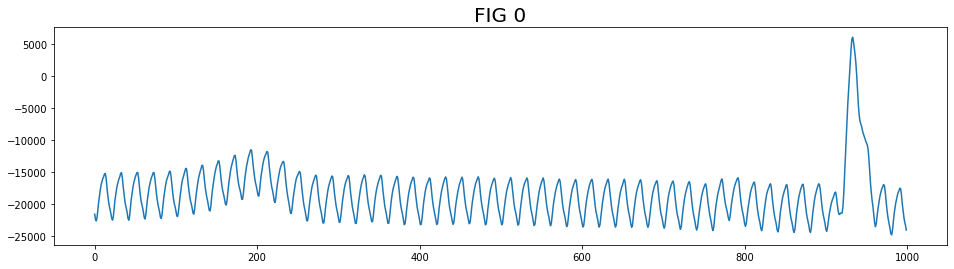

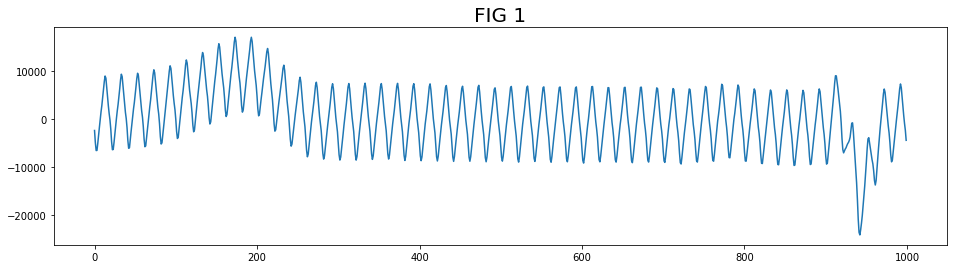

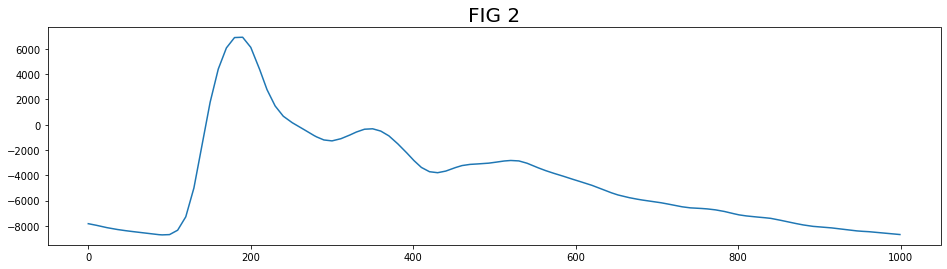

In [4]:
# Extract single subject
sigs, metadata = extract_data(
    os.path.join(dir_path, files_dat[DATA_ID]),
    os.path.join(dir_path, files_hea[DATA_ID]),
    raw_dtype='int16'
)



# Each subject has three 'channels': two ecg and one pulse
# not really
for i in range(len(sigs)):
    plt.figure(i, figsize=(16, 4))
    plt.plot(sigs[i][500:1500])
    plt.title('FIG '+str(i), size=20)

## Finding peaks with Scipy

<class 'numpy.ndarray'>


/tmp/ipykernel_13138/3607142093.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data, fs = np.array(shorten(data,1000,120))


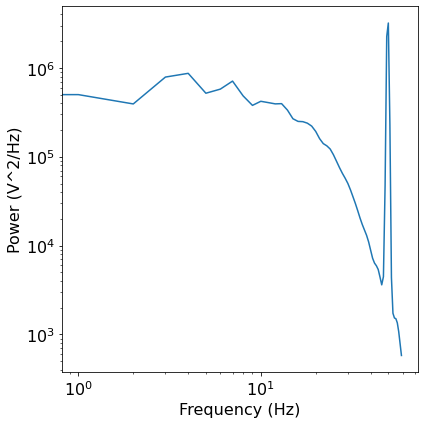

In [5]:
data = sigs[0]
fs = 1000
f_range_hi = (FREQ_HIGHPASS, None)


print(type(data))
data, fs = np.array(shorten(data,1000,120))
fr,sp = compute_spectrum(sig=data,fs=fs)
plot_power_spectra(fr,sp)

/home/guarian/.local/lib/python3.10/site-packages/neurodsp/filt/filter.py:96: UserWarning: Edge artifacts are not removed when using an IIR filter.
  warn('Edge artifacts are not removed when using an IIR filter.')


[     0      1      2 ... 232593 232594 232595]


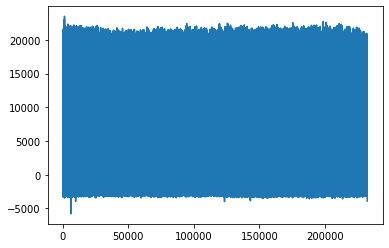

[nan nan nan ... nan nan nan]


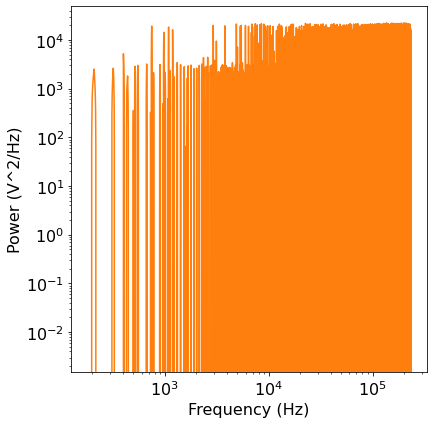

In [6]:
# Highpass filter to remove drift
sig_filt = filter_signal(data, fs, 'highpass', f_range_hi)
sig_filt = filter_signal(sig_filt, fs, 'bandstop', f_range=(40,55), filter_type='iir', butterworth_order=3)
times = np.arange(0, sig_filt.shape[0])
print(times)

ts = sig_filt

plt.plot(np.linspace(0,len(ts), len(ts)), ts)
plt.show()

freqs, spectra = compute_spectrum(sig_filt, fs)
plot_power_spectra(freqs, spectra)
# freqs, spectra = compute_spectrum(windowed_smoothed_data, fs)
# plot_power_spectra(freqs, spectra)

# smoothing for finding control points
datalen = len(data)
# https://www.statsmodels.org/dev/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html
data_smoothed = linear_smoothing(sig_filt,H_VAL)
print(data_smoothed)
plt.plot(times, data_smoothed)



In [7]:
# output= pd.read_csv(index_col=0,filepath_or_buffer= 'gaussianTable.csv')
# output

In [8]:
# First find R peaks
peaks = find_peaks(sig_filt, height=10000, distance=500)
idx_rvals = peaks[0] # spike indices
amp_rvals = peaks[1]['peak_heights'] # spike amplitudes

In [9]:
# Number of R peaks found
idx_rvals.shape

(338,)

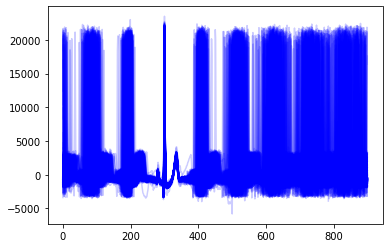

In [10]:
# Plotting all windowed cycles to find generalizable window length
for idx, cycle in enumerate(idx_rvals[1:]):
    #times declaratio nmoved to sig_filt declaration. saves on allocations and increases availability.

    # create window indices
    window_length = (300, 600)  # in ms
    window_pre = int(window_length[0])
    window_post = int(window_length[1])

    # get window
    window_cycle_pre = (cycle-window_pre)
    window_cycle_post = (cycle+window_post)

    # get window for times as well
    windowed_times = times[(cycle-window_pre):
                           (cycle+window_post)]
    windowed_times = np.arange(0, windowed_times.shape[0])

    # get data window
    windowed_data = sig_filt[window_cycle_pre:window_cycle_post]
    windowed_smoothed_data = data_smoothed[window_cycle_pre:window_cycle_post]

    plt.plot(windowed_times, windowed_data, 'b', alpha=0.2)
    # plt.plot(windowed_times, windowed_data-windowed_smoothed_data, 'r', alpha=0.8)
    # plt.plot(windowed_times, windowed_smoothed_data, 'g', alpha=0.8)
    #plt.plot(cycle, amp_rvals[idx], 'o')

plt.show()


In [11]:
idx_pvals = np.zeros(idx_rvals.shape)
amp_pvals = np.zeros(idx_rvals.shape)
idx_max = -np.inf
peak_max = -np.inf

p = []
q = []
r = []
s = []
t = []
u = []
qs = []
windowed_data_collection = []
smoothed_windowed_data_collection = []
rolling_index = 0
cycle_starts = []
cycle_lengths = []
failing_cases = [478, 575]
errstring = 'Failing case: '
for idx, cycle in enumerate(idx_rvals[:]):
    print(idx)
    # if idx in failing_cases:
    #     continue
    if idx > 20:
        break
    times = np.arange(0, sig_filt.shape[0])
    # create window indices
    window_length = (300, 600)  # in ms
    window_pre = int(window_length[0])
    window_post = int(window_length[1])
    # get window
    window_cycle_pre = (cycle-window_pre)
    window_cycle_post = (cycle+window_post)
    # get window for times as well
    windowed_times = times[(cycle-window_pre):
                           (cycle+window_post)]
    windowed_times = np.arange(0, windowed_times.shape[0])
    # get data window
    windowed_data = sig_filt[window_cycle_pre:window_cycle_post]
    windowed_smoothed_data = data_smoothed[window_cycle_pre:window_cycle_post]
    # P peaks
    r_idx = 299
    r_idx, _ = find_max(windowed_data, r_idx-50, r_idx+50)
    if r_idx == -1 or r_idx == len(windowed_data):
        #print(errstring + str(idx))
        failing_cases.append(idx)
        continue
    q_idx = time_series_polarity_change(
        time_series=windowed_smoothed_data, idx=r_idx, offset=H_VAL, direction=-1)
    if q_idx == -1:
        #print(errstring + str(idx))
        failing_cases.append(idx)
        continue
        
    p_idx = time_series_polarity_change(
        time_series=windowed_smoothed_data, idx=q_idx, offset=H_VAL, direction=-1)
    if p_idx == -1:
        #print(errstring + str(idx))
        failing_cases.append(idx)
        continue
    smooth_r_idx, _ = find_max(
        time_series=windowed_smoothed_data, left=0, right=len(windowed_smoothed_data))
    if smooth_r_idx == -1 or smooth_r_idx == len(windowed_smoothed_data):
        #print(errstring + str(idx))
        failing_cases.append(idx)
        continue
    p_idx, _ = find_max(time_series=windowed_smoothed_data,
                        left=0, right=q_idx)
    if p_idx == -1 or p_idx == len(windowed_smoothed_data):
        #print(errstring + str(idx))
        failing_cases.append(idx)
        continue
    # print(smooth_r_idx)
    r_increase_or_decrease = disc_derivative(
        time_series=windowed_data, x_val=smooth_r_idx, h_val=1)
    if r_increase_or_decrease > 0:
        smooth_r_idx = smooth_r_idx+25
    s_idx = time_series_polarity_change(
        time_series=windowed_smoothed_data, idx=smooth_r_idx, offset=5, direction=1)
    if s_idx == -1:
        #print(errstring + str(idx))
        failing_cases.append(idx)
        continue
    # print(s_idx)
    t_idx, _ = find_max(time_series=windowed_smoothed_data,
                        left=s_idx, right=len(windowed_smoothed_data))
    if t_idx == -1 or t_idx == len(windowed_smoothed_data):
        #print(errstring + str(idx))
        failing_cases.append(idx)
        continue
    # print(t_idx)
    left_u_bound = time_series_polarity_change(
        time_series=windowed_smoothed_data, idx=t_idx, offset=H_VAL, direction=1)
    right_u_bound = time_series_polarity_change(time_series=windowed_smoothed_data, idx=len(
        windowed_smoothed_data)-1, offset=H_VAL, direction=-1)
    u_idx, _ = find_max(time_series=windowed_smoothed_data,
                        left=left_u_bound, right=right_u_bound)
    
    if left_u_bound == -1 or right_u_bound == -1 or u_idx == -1 or u_idx == len(windowed_smoothed_data):
        #print(errstring + str(idx))
        failing_cases.append(idx)
        continue

    # Now we use the real (adjusted) R value.
    r_idx = 299

    # adding these to an array to make the matplotlib stuff faster.
    # I think it replots the whole graph each time plot is called,
    # so I'll call it once. Can't hurt
    # It Worked!!!!!
    p.append(p_idx)
    q.append(q_idx)
    r.append(r_idx)
    s.append(s_idx)
    t.append(t_idx)
    u.append(u_idx)
    qs.append(s_idx-q_idx)
    windowed_data_collection.append(windowed_data)
    smoothed_windowed_data_collection.append(windowed_smoothed_data)
    cycle_starts.append(window_cycle_pre)
    cycle_lengths.append(len(windowed_data))

    plt.plot(windowed_times, sig_filt[window_cycle_pre:window_cycle_post], 'b', alpha=0.8)
    # plt.plot(windowed_times, windowed_data-windowed_smoothed_data, 'r', alpha=0.8)
    # plt.plot(windowed_times, windowed_smoothed_data, 'r', alpha=0.8)
    plt.plot(windowed_times[p_idx], sig_filt[p_idx], 'o')
    plt.plot(windowed_times[q_idx], sig_filt[q_idx], 'o')
    plt.plot(windowed_times[r_idx], sig_filt[r_idx], 'o')
    plt.plot(windowed_times[s_idx], sig_filt[s_idx], 'o')
    plt.plot(windowed_times[t_idx], sig_filt[t_idx], 'o')
    plt.plot(windowed_times[u_idx], sig_filt[u_idx], 'o')
print("all cycles plotted")
plt.show()

print("failing_cases: " + str(failing_cases))

p_co = []
q_co = []
r_co = []
s_co = []
t_co = []
u_co = []

# asserting here that all the arrays are the same length
for i in range(len(p)):
    p_co.append(windowed_data[p[i]])
    q_co.append(windowed_data[q[i]])
    r_co.append(windowed_data[r[i]])
    s_co.append(windowed_data[s[i]])
    t_co.append(windowed_data[t[i]])
    u_co.append(windowed_data[u[i]])



0
1
2
3
4
5


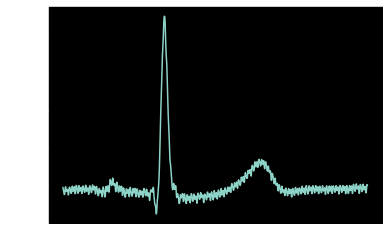

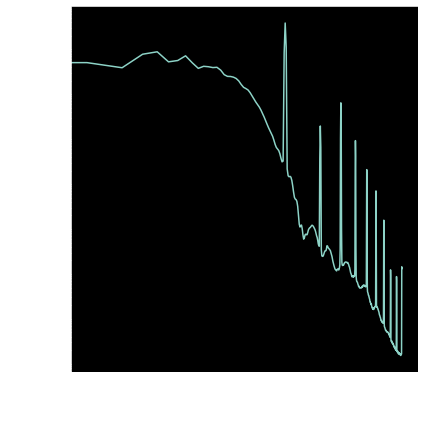

In [ ]:
ts = windowed_data_collection[0]

plt.plot(np.linspace(0,len(ts), len(ts)), ts)
plt.show()

freqs, spectra = compute_spectrum(data, fs)
plot_power_spectra(freqs, spectra)
# freqs, spectra = compute_spectrum(windowed_smoothed_data, fs)
# plot_power_spectra(freqs, spectra)


Gradient Descent Gaussian Stuff

but here tho
should be returning: [144] and [152]
([144], [152])
left: 0
middle: 270
right: 1e+99
should be returning: [161] and [283]
should be returning: [328] and [498]


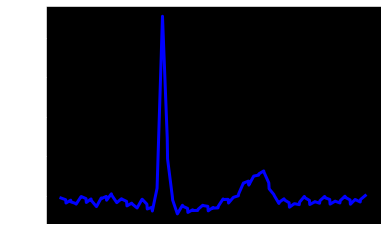

In [ ]:
data_for_df = []
divisors = np.linspace(1, 70, 70)
smoothing_interval = H_VAL

# changed or added everything above here
# print("one cycle plotted alone")
# plt.plot(np.linspace(0,cycle_lengths[0],cycle_lengths[0]), windowed_data_collection[0], 'r')
plt.show()

highests = []
highest_idx = - 1
smoothing_interval = 15

# # https://stackoverflow.com/questions/4971269/how-to-pick-a-new-color-for-each-plotted-line-within-a-figure-in-matplotlib
# color = iter(cm.rainbow(np.linspace(0, 1, len(divisors))))
# for i in range(len(divisors)):
#     # if i==0:
#     #     plt.plot(np.linspace(0,cycle_lengths[0],cycle_lengths[0]), smoothed_data, 'g', alpha=0.8)
#     #     continue
#     smoothing_interval = math.floor(qs[0]/divisors[i])
#     if smoothing_interval == 0:
#         smoothing_interval = 1
#     # print(qs[i], divisors[i], smoothing_interval)
#     smoothed_data = linear_smoothing(
#         sig_filt[cycle_starts[0]:cycle_starts[0]+cycle_lengths[0]], smoothing_interval)
#     if smoothed_data is None:
#         # print("smoothing failed")
#         shouldibreak = True
#         break
#     highests.append(smoothed_data[650])
#     # plt.plot(np.linspace(0,cycle_lengths[0],cycle_lengths[0]), smoothed_data, next(color), linewidth=1)

# print("highests: " + str(highests))
# plt.show()

ctrl_pt_bounds = []
sm_data = None

# print(str(len(divisors)))
# print("smoothing_interval: " + str(smoothing_interval))
smoothed_data = linear_smoothing(sig_filt[cycle_starts[0]:cycle_starts[0]+cycle_lengths[0]], smoothing_interval)
plt.plot(np.linspace(0,cycle_lengths[0],cycle_lengths[0]), smoothed_data, 'b', linewidth=3)
print("but here tho")
ctrl_pt_bounds = []
bounds= find_intercepts_telescoping(time_series=smoothed_data, tgt=0, left_b=0, right_b=1e99, center=p[0])
print(bounds)
ctrl_pt_bounds.append(0)
print("left: " + str(0))
print("middle: " + str(q[0]))
print("right: "+str(1e99))
left, right = find_intercepts_telescoping(windowed_data_collection[0], 0, 0, 1e99, q[0])
ctrl_pt_bounds.append(int(left[0]))
ctrl_pt_bounds.append(int(right[0]))
left, right = find_intercepts_telescoping(windowed_data_collection[0], 0, 0, 1e99, s[0])
ctrl_pt_bounds.append(int(left[0]))
ctrl_pt_bounds.append(int(right[0]))
ctrl_pt_bounds.append(len(windowed_data_collection[0]))
# print("here")
sm_data = smoothed_data

# # plt.show()

# print("ctrl_pt_bounds: " + str(ctrl_pt_bounds))
# p_series = sm_data[ctrl_pt_bounds[0]:ctrl_pt_bounds[1]]
# # plt.plot(np.linspace(0,len(p_series),len(p_series)), p_series, 'r', linewidth=3)
# p_gaussian = fit_curve(sig=p_series, p0=[0, 100, -1, 0], bounds=([0, 0, -1e9, -1e9], [1e9, 1e9, 0, 1e9]))
# plt.plot(np.linspace(0,len(p_series),len(p_series)), skewed_gaussian(np.linspace(0,len(p_series),len(p_series)), *p_gaussian), 'g', linewidth=3)
# plt.plot(np.linspace(0,len(p_series),len(p_series)), p_series, 'r', linewidth=3)
# plt.show()
# print("p_gaussian: ")
# print("p_bounds: " + str(ctrl_pt_bounds))

# q_series = sm_data[ctrl_pt_bounds[1]:ctrl_pt_bounds[2]]
# q_gaussian = fit_curve(sig=q_series, p0=[0, 35, -1, 0], bounds=([-1e9, 0, -1e9, -1e9], [0, len(p_series)-1, 0, 1e9]))

# r_series = sm_data[ctrl_pt_bounds[2]:ctrl_pt_bounds[3]]
# print("r_series: " + str(r_series))
# r_gaussian = fit_curve(sig=r_series, p0=[0, 35, -1, 0], bounds=([0, 0, -1e9, -1e9], [1e9, 55, 0, 1e9]))

# s_series = sm_data[ctrl_pt_bounds[3]:ctrl_pt_bounds[4]]
# s_gaussian = fit_curve(sig=s_series, p0=[0, 35, -1, 0], bounds=([-1e9, 0, -1e9, -1e9], [0, 100, 0, 1e9]))

# t_series = sm_data[ctrl_pt_bounds[4]:ctrl_pt_bounds[5]]
# t_gaussian = fit_curve(sig=t_series, p0=[0, 35, -1, 0], bounds=([0, 0, -1e9, -1e9], [1e9, 1e9, 0, 1e9]))
# print("t bounds: " + str(ctrl_pt_bounds[4]) + " " + str(ctrl_pt_bounds[5]))
# # plt.plot(np.linspace(0, len(t_series), len(t_series)),
# #         t_series, 'r', linewidth=3)
# # plt.show()

# p_gaussian[1] += ctrl_pt_bounds[0]
# q_gaussian[1] += ctrl_pt_bounds[1]
# r_gaussian[1] += ctrl_pt_bounds[2]
# s_gaussian[1] += ctrl_pt_bounds[3]
# t_gaussian[1] += ctrl_pt_bounds[4]
# # make a figure for the plot
# fig = plt.figure(figsize=(10, 10))
# plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), skewed_gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *p_gaussian), 'g', linewidth=3)
# plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), skewed_gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *q_gaussian), 'g', linewidth=3)
# plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), skewed_gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *r_gaussian), 'g', linewidth=3)
# plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), skewed_gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *s_gaussian), 'g', linewidth=3)
# plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), skewed_gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *t_gaussian), 'g', linewidth=3)
# plt.show()

# a = skewed_gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *p_gaussian)
# b = skewed_gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *q_gaussian)
# c = skewed_gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *r_gaussian)
# d = skewed_gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *s_gaussian)
# e = skewed_gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *t_gaussian)

# fig = plt.figure(figsize=(10, 10))
# plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]),
#          sig_filt[cycle_starts[0]:cycle_starts[0]+cycle_lengths[0]], 'r', linewidth=3)
# plt.show()
# plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), a+b+c+d+e, 'r', linewidth=3)
# plt.show()
# # # the stuff that matters:
# print(p_gaussian)
# print(q_gaussian)
# print(r_gaussian)
# print(s_gaussian)
# print(t_gaussian)

# # and below here and in between to match the indices from the top section
# newData = [0, p_gaussian[0], p_gaussian[1], p_gaussian[2], p_gaussian[3], q_gaussian[0], q_gaussian[1], q_gaussian[2], q_gaussian[3], r_gaussian[0], r_gaussian[1], r_gaussian[2], r_gaussian[3], s_gaussian[0], s_gaussian[1], s_gaussian[2], p_gaussian[3], t_gaussian[0], t_gaussian[1],
#            t_gaussian[2], p_gaussian[3]]
# data_for_df.append(newData)

# # print(data_for_df)
# x = pd.DataFrame(data_for_df, columns=['cycle index', 'p_amplitude', 'p_b', 'p_c', 'p_center', 'q_amplitude',
#                                        'q_b', 'q_c', 'q_center', 'r_amplitude', 'r_b', 'r_c', 'r_center', 's_amplitude', 's_b', 's_c', 's_center', 't_amplitude', 't_b', 't_c', 't_center'])
# display(x)
# x.to_csv("gaussianTable.csv")


In [ ]:
gaussians = []

for i in range(len(windowed_data_collection)):
    try:
        result,cov = fit_n_gaussian_center_bounds(
            x=windowed_data_collection[i],
            b_bounds=[(p[i]-30,p[i]+30),
                    (q[i]-30,q[i]+30),
                    (r[i]-30,r[i]+30),
                    (s[i]-30,s[i]+30),
                    (t[i]-30,t[i]+30)])
        
        gaussians.append(result)
    except:
        gaussians.append(np.zeros(20))
print(len(gaussians))


5
5
5
5
20
20
bounds: ([-1e+20, 116, -1, -1e+20, -1e+20, 240, -1, -1e+20, -1e+20, 269, -1, -1e+20, -1e+20, 311, -1, -1e+20, -1e+20, 556, -1, -1e+20], [1e+20, 176, 0, 1e+20, 1e+20, 300, 0, 1e+20, 1e+20, 329, 0, 1e+20, 1e+20, 371, 0, 1e+20, 1e+20, 616, 0, 1e+20])
guesses: [2000, 146.0, -0.001, 0, 2000, 270.0, -0.001, 0, 2000, 299.0, -0.001, 0, 2000, 341.0, -0.001, 0, 2000, 586.0, -0.001, 0]


/tmp/ipykernel_4715/2329781076.py:167: RuntimeWarning: overflow encountered in exp
  return a*np.exp(c*((x-b)**2))
/tmp/ipykernel_4715/2329781076.py:178: RuntimeWarning: invalid value encountered in multiply
  skewed_function = 2*cdf*normal_gaussian
/tmp/ipykernel_4715/2329781076.py:167: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(c*((x-b)**2))


5
5
5
5
20
20
bounds: ([-1e+20, 113, -1, -1e+20, -1e+20, 240, -1, -1e+20, -1e+20, 269, -1, -1e+20, -1e+20, 322, -1, -1e+20, -1e+20, 553, -1, -1e+20], [1e+20, 173, 0, 1e+20, 1e+20, 300, 0, 1e+20, 1e+20, 329, 0, 1e+20, 1e+20, 382, 0, 1e+20, 1e+20, 613, 0, 1e+20])
guesses: [2000, 143.0, -0.001, 0, 2000, 270.0, -0.001, 0, 2000, 299.0, -0.001, 0, 2000, 352.0, -0.001, 0, 2000, 583.0, -0.001, 0]


/tmp/ipykernel_4715/2329781076.py:178: RuntimeWarning: overflow encountered in multiply
  skewed_function = 2*cdf*normal_gaussian


5
5
5
5
20
20
bounds: ([-1e+20, 111, -1, -1e+20, -1e+20, 240, -1, -1e+20, -1e+20, 269, -1, -1e+20, -1e+20, 296, -1, -1e+20, -1e+20, 561, -1, -1e+20], [1e+20, 171, 0, 1e+20, 1e+20, 300, 0, 1e+20, 1e+20, 329, 0, 1e+20, 1e+20, 356, 0, 1e+20, 1e+20, 621, 0, 1e+20])
guesses: [2000, 141.0, -0.001, 0, 2000, 270.0, -0.001, 0, 2000, 299.0, -0.001, 0, 2000, 326.0, -0.001, 0, 2000, 591.0, -0.001, 0]
5
5
5
5
20
20
bounds: ([-1e+20, 111, -1, -1e+20, -1e+20, 250, -1, -1e+20, -1e+20, 269, -1, -1e+20, -1e+20, 311, -1, -1e+20, -1e+20, 551, -1, -1e+20], [1e+20, 171, 0, 1e+20, 1e+20, 310, 0, 1e+20, 1e+20, 329, 0, 1e+20, 1e+20, 371, 0, 1e+20, 1e+20, 611, 0, 1e+20])
guesses: [2000, 141.0, -0.001, 0, 2000, 280.0, -0.001, 0, 2000, 299.0, -0.001, 0, 2000, 341.0, -0.001, 0, 2000, 581.0, -0.001, 0]
5
5
5
5
20
20
bounds: ([-1e+20, 109, -1, -1e+20, -1e+20, 240, -1, -1e+20, -1e+20, 269, -1, -1e+20, -1e+20, 319, -1, -1e+20, -1e+20, 568, -1, -1e+20], [1e+20, 169, 0, 1e+20, 1e+20, 300, 0, 1e+20, 1e+20, 329, 0, 1e+20,

/tmp/ipykernel_4715/2329781076.py:218: RuntimeWarning: invalid value encountered in add
  retData = retData+skewed_gaussian(x, a[i], b[i], c[i], d[i])


5
5
5
5
20
20
bounds: ([-1e+20, 118, -1, -1e+20, -1e+20, 240, -1, -1e+20, -1e+20, 269, -1, -1e+20, -1e+20, 308, -1, -1e+20, -1e+20, 558, -1, -1e+20], [1e+20, 178, 0, 1e+20, 1e+20, 300, 0, 1e+20, 1e+20, 329, 0, 1e+20, 1e+20, 368, 0, 1e+20, 1e+20, 618, 0, 1e+20])
guesses: [2000, 148.0, -0.001, 0, 2000, 270.0, -0.001, 0, 2000, 299.0, -0.001, 0, 2000, 338.0, -0.001, 0, 2000, 588.0, -0.001, 0]
5
5
5
5
20
20
bounds: ([-1e+20, 116, -1, -1e+20, -1e+20, 250, -1, -1e+20, -1e+20, 269, -1, -1e+20, -1e+20, 317, -1, -1e+20, -1e+20, 556, -1, -1e+20], [1e+20, 176, 0, 1e+20, 1e+20, 310, 0, 1e+20, 1e+20, 329, 0, 1e+20, 1e+20, 377, 0, 1e+20, 1e+20, 616, 0, 1e+20])
guesses: [2000, 146.0, -0.001, 0, 2000, 280.0, -0.001, 0, 2000, 299.0, -0.001, 0, 2000, 347.0, -0.001, 0, 2000, 586.0, -0.001, 0]
5
5
5
5
20
20
bounds: ([-1e+20, 106, -1, -1e+20, -1e+20, 240, -1, -1e+20, -1e+20, 269, -1, -1e+20, -1e+20, 312, -1, -1e+20, -1e+20, 557, -1, -1e+20], [1e+20, 166, 0, 1e+20, 1e+20, 300, 0, 1e+20, 1e+20, 329, 0, 1e+20,

In [ ]:
gauss_sigs =[]

print(len(gaussians))

for i in range(len(gaussians)):
    print(i)
    currgaussian = gaussians[i]
    gaussian_to_append = []
    for j in range(len(currgaussian)):
        if j%4!=1:
            gaussian_to_append.append(currgaussian[j])
    gauss_sigs.append(gaussian_to_append)
    
print(len(gauss_sigs))

df = pd.DataFrame(gauss_sigs).T
print(df.shape)
res = df.corr()
print(res.shape)

gaussian_corr = np.zeros(df.shape[1])
for i in range(0, df.shape[1]):
    for j in range(0,df.shape[1]):
        gaussian_corr[j] = gaussian_corr[j] + res[i][j]
    
score_indices = np.argsort(gaussian_corr)
score_indices = np.flip(score_indices)

df.to_csv("gauss_corr_"+str(DATA_ID)+".csv")
sc = pd.DataFrame(score_indices)
sc.to_csv("gauss_scores_"+str(DATA_ID)+".csv")

# sns.heatmap(res, cmap="Greens",annot=True)

# print(df.shape)
# res = df.corr()
# lenres = len(res)
# # min, min_idx, max, max_idx
# resdata = [np.zeros(lenres),np.zeros(lenres),np.zeros(lenres),np.zeros(lenres)]

2032
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

In [ ]:
new_sigs =[]
results = []
curr_result=[]

for i in range(len(windowed_data_collection)):
    new_sigs.append(windowed_data_collection[i])
    
print(len(new_sigs))

df = pd.DataFrame(new_sigs).T
res = df.corr()

scores = np.zeros(df.shape[1])
for i in range(0, df.shape[1]):
    for j in range(0,df.shape[1]):
        scores[j] = scores[j] + res[i][j]
    
score_indices = np.argsort(scores)
score_indices = np.flip(score_indices)

print(df.shape)
print(res.shape)
print(scores)
print(score_indices)

for idx in range(0,len(smoothed_windowed_data_collection)):
    curr_result.append(idx)
    curr_result.append(gaussians[idx])
    curr_result.append(score_indices[idx])
    curr_result.append(scores[idx])
    results.append(curr_result)

# df.to_csv("signal_corr_"+str(DATA_ID)+".csv")
# sc = pd.DataFrame(scores)
# sc.to_csv("signal_corr_scores_"+str(DATA_ID)+".csv")

result_df = pd.DataFrame(results)



2032
(900, 2032)
(2032, 2032)
[1994.25754203 1975.44264796 1994.01258543 ... 1962.87200501 1953.4664994
 1955.59301452]
[ 943  958  966 ...   51   47 1213]


In [ ]:

result_df = result_df
result_df.to_csv("result_"+str(DATA_ID)+".csv")

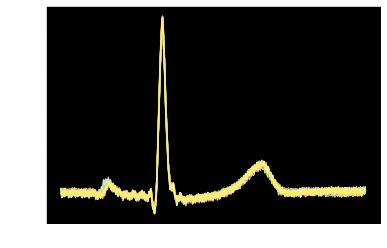

In [ ]:

# for i in score_indices[1:10]:
#     plt.plot(np.linspace(0,len(windowed_data_collection[i]),len(windowed_data_collection[i])), windowed_data_collection[i])
for i in score_indices[0:10]:
    plt.plot(np.linspace(0,len(windowed_data_collection[i]),len(windowed_data_collection[i])), windowed_data_collection[i])

plt.show()

In [ ]:

print(df.shape)
res = df.corr()
print(res.shape)
# sns.heatmap(res, cmap="Greens",annot=True)


# print(df.shape)
# res = df.corr()
# lenres = len(res)
# # min, min_idx, max, max_idx
# resdata = [np.zeros(lenres),np.zeros(lenres),np.zeros(lenres),np.zeros(lenres)]


(900, 2032)
(2032, 2032)


In [ ]:
from turtle import color

plt.plot(times,time_series, label="filtered signal")
plt.plot(times,CURVE_FIT_5_skewed_gaussian(times,*result), label="Gaussian-fitted signal")
plt.legend()
p_params = result[0:4]
skgauss = skewed_gaussian(times,*result[0:4])
print(p_params)
# plt.plot(times, skgauss, color='r')
print(result)

NameError: name 'time_series' is not defined

900
0


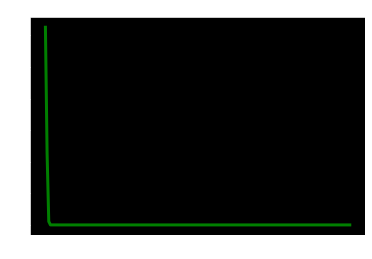

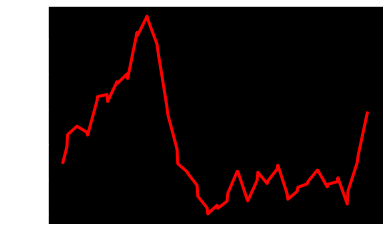

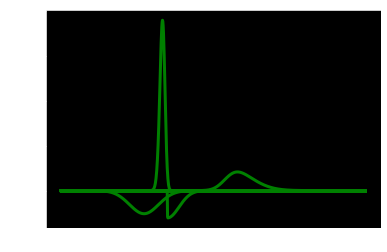

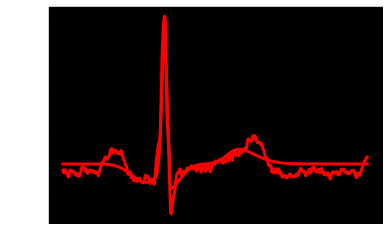

[ 1.25181778e-17  1.00000000e-10 -1.00000000e+00  0.00000000e+00]
[-2.57819958e+03  2.45879682e+02 -2.72126633e-04 -2.63757829e-05]
[ 1.44330452e+04  3.05765933e+02 -5.07564147e-03 -1.32288576e-01]
[-1.52450547e+03  3.14887141e+02 -4.30604914e-04  3.74334202e+00]
[ 1.34899072e+03  4.87955166e+02 -1.14887283e-04  3.45529319e-02]


In [ ]:
print(len(sm_data))
print(ctrl_pt_bounds[0])

p_series = sm_data[ctrl_pt_bounds[0]:ctrl_pt_bounds[1]]
# plt.plot(np.linspace(0,len(p_series),len(p_series)), p_series, 'r', linewidth=3)
p_gaussian = fit_curve(sig=p_series, p0=[0, 0, -1,0], bounds=([0, 0, -1e9, -1e9], [1e9, len(p_series), 0, 1e9]))
plt.plot(np.linspace(0,len(p_series),len(p_series)), skewed_gaussian(np.linspace(0,len(p_series),len(p_series)), *p_gaussian), 'g', linewidth=3)
plt.show()

q_series = sm_data[ctrl_pt_bounds[1]:ctrl_pt_bounds[2]]
q_gaussian = fit_curve(sig=q_series, p0=[0, 35, -1, 0], bounds=([-1e9, 0, -1e9, -1e9], [0, len(q_series), 0, 1e9]))

r_series = sm_data[ctrl_pt_bounds[2]:ctrl_pt_bounds[3]]
r_gaussian = fit_curve(sig=r_series, p0=[0, 35, -1, 0], bounds=([0, 0, -1e9, -1e9], [1e9, 55, 0, 1e9]))

s_series = sm_data[ctrl_pt_bounds[3]:ctrl_pt_bounds[4]]
s_gaussian = fit_curve(sig=s_series, p0=[0, 35, -1, 0], bounds=([-1e9, 0, -1e9, -1e9], [0, 200, 0, 1e9]))

t_series = sm_data[ctrl_pt_bounds[4]:ctrl_pt_bounds[5]]
t_gaussian = fit_curve(sig=t_series, p0=[0, 35, -1, 0], bounds=([0, 0, -1e9, -1e9], [1e9, 200, 0, 1e9]))
plt.plot(np.linspace(0, len(t_series), len(t_series)),
         t_series, 'r', linewidth=3)
plt.show()

p_gaussian[1] += ctrl_pt_bounds[0]
q_gaussian[1] += ctrl_pt_bounds[1]
r_gaussian[1] += ctrl_pt_bounds[2]
s_gaussian[1] += ctrl_pt_bounds[3]
t_gaussian[1] += ctrl_pt_bounds[4]
plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), skewed_gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *p_gaussian), 'g', linewidth=3)
plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), skewed_gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *q_gaussian), 'g', linewidth=3)
plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), skewed_gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *r_gaussian), 'g', linewidth=3)
plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), skewed_gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *s_gaussian), 'g', linewidth=3)
plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), skewed_gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *t_gaussian), 'g', linewidth=3)
plt.show()

a = skewed_gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *p_gaussian)
b = skewed_gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *q_gaussian)
c = skewed_gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *r_gaussian)
d = skewed_gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *s_gaussian)
e = skewed_gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *t_gaussian)

plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), sig_filt[cycle_starts[0]:cycle_starts[0]+cycle_lengths[0]], 'r', linewidth=3)
plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), a+b+c+d+e, 'r', linewidth=3)
plt.show()
# the stuff that matters:
print(p_gaussian)
print(q_gaussian)
print(r_gaussian)
print(s_gaussian)
print(t_gaussian)

newData = [p_gaussian[0], p_gaussian[1], p_gaussian[2], q_gaussian[0], q_gaussian[1], q_gaussian[2], r_gaussian[0], r_gaussian[1], r_gaussian[2], s_gaussian[0], s_gaussian[1], s_gaussian[2], t_gaussian[0], t_gaussian[1],
           t_gaussian[2]]


## Finding peaks with Bycycle

In [ ]:
fs = 1000
f_range_hi = (1, None)
f_range_band = (4, 10)

In [ ]:
# Highpass filter to remove drift
sig_filt = filter_signal(sigs[0], fs, 'highpass', f_range_hi)

In [ ]:
peaks, troughs = bycycle.cyclepoints.find_extrema(sig_filt, fs, f_range_band)

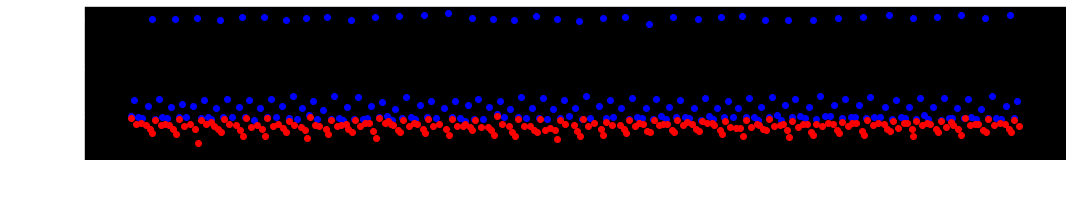

In [ ]:
bycycle.plts.plot_cyclepoints_array(sig_filt, fs, peaks=peaks, troughs=troughs, xlim=(25, 60))

In [ ]:
peaks.shape

(5599,)

In [ ]:
sig_peaks = sig_filt[peaks]

In [ ]:
# Filter the peaks to only find the ones that are above 1 standard deviation of the mean voltage
mean = np.mean(sig_peaks)
std = np.std(sig_peaks)
mask = sig_peaks > (mean+std)

In [ ]:
r_vals = sig_peaks[mask]

In [ ]:
r_vals_times = peaks[mask]

In [ ]:
r_vals

array([20625.10013036, 20880.27800796, 19741.05817686, ...,
       20364.47631484, 20736.21874733, 21003.33047705])

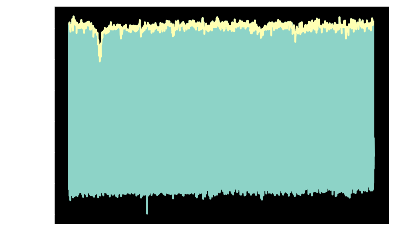

In [ ]:
plt.plot(sig_filt)
plt.plot(r_vals_times, r_vals)